In [1]:
!pip install pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 8.4 MB/s eta 0:00:00a 0:00:01


In [2]:
import os
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
import matplotlib.patches as patches
import json
import torch 
from torch.utils.data import Dataset, DataLoader 
import torchvision
from torchvision import transforms
from torchvision import tv_tensors
import torchvision.models as models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import v2 as T
from engine import train_one_epoch, evaluate
import utils
from torchvision.io import read_image
import time

--2024-07-12 01:37:48--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4063 (4.0K) [text/plain]
Saving to: 'engine.py'

     0K ...                                                   100% 29.5M=0s

2024-07-12 01:37:48 (29.5 MB/s) - 'engine.py' saved [4063/4063]

--2024-07-12 01:37:48--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8388 (8.2K) [text/plain]
Savin

In [3]:
with open('/kaggle/input/coco-2017-dataset/coco2017/annotations/instances_val2017.json') as val_json:
    val_file = json.load(val_json)

with open('/kaggle/input/coco-2017-dataset/coco2017/annotations/instances_train2017.json') as train_json:
    train_file = json.load(train_json)

In [4]:
val_file.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [5]:
train_file.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [6]:
val_file['images'][0].keys()

dict_keys(['license', 'file_name', 'coco_url', 'height', 'width', 'date_captured', 'flickr_url', 'id'])

In [7]:
train_file['images'][0].keys()

dict_keys(['license', 'file_name', 'coco_url', 'height', 'width', 'date_captured', 'flickr_url', 'id'])

In [8]:
val_file['images'][0]

{'license': 4,
 'file_name': '000000397133.jpg',
 'coco_url': 'http://images.cocodataset.org/val2017/000000397133.jpg',
 'height': 427,
 'width': 640,
 'date_captured': '2013-11-14 17:02:52',
 'flickr_url': 'http://farm7.staticflickr.com/6116/6255196340_da26cf2c9e_z.jpg',
 'id': 397133}

In [9]:
val_file['annotations'][0].keys()

dict_keys(['segmentation', 'area', 'iscrowd', 'image_id', 'bbox', 'category_id', 'id'])

In [10]:
train_file['annotations'][0].keys()

dict_keys(['segmentation', 'area', 'iscrowd', 'image_id', 'bbox', 'category_id', 'id'])

In [11]:
val_file['annotations'][0]

{'segmentation': [[510.66,
   423.01,
   511.72,
   420.03,
   510.45,
   416.0,
   510.34,
   413.02,
   510.77,
   410.26,
   510.77,
   407.5,
   510.34,
   405.16,
   511.51,
   402.83,
   511.41,
   400.49,
   510.24,
   398.16,
   509.39,
   397.31,
   504.61,
   399.22,
   502.17,
   399.64,
   500.89,
   401.66,
   500.47,
   402.08,
   499.09,
   401.87,
   495.79,
   401.98,
   490.59,
   401.77,
   488.79,
   401.77,
   485.39,
   398.58,
   483.9,
   397.31,
   481.56,
   396.35,
   478.48,
   395.93,
   476.68,
   396.03,
   475.4,
   396.77,
   473.92,
   398.79,
   473.28,
   399.96,
   473.49,
   401.87,
   474.56,
   403.47,
   473.07,
   405.59,
   473.39,
   407.71,
   476.68,
   409.41,
   479.23,
   409.73,
   481.56,
   410.69,
   480.4,
   411.85,
   481.35,
   414.93,
   479.86,
   418.65,
   477.32,
   420.03,
   476.04,
   422.58,
   479.02,
   422.58,
   480.29,
   423.01,
   483.79,
   419.93,
   486.66,
   416.21,
   490.06,
   415.57,
   492.18,
   416.85,

In [12]:
val_file['categories'][0].keys()

dict_keys(['supercategory', 'id', 'name'])

In [13]:
val_file['categories']

[{'supercategory': 'person', 'id': 1, 'name': 'person'},
 {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'vehicle', 'id': 3, 'name': 'car'},
 {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'},
 {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'},
 {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'},
 {'supercategory': 'vehicle', 'id': 7, 'name': 'train'},
 {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'},
 {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'},
 {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'},
 {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'},
 {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'},
 {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'},
 {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'},
 {'supercategory': 'animal', 'id': 16, 'name': 'bird'},
 {'supercategory': 'animal', 'id': 17, 'name': 'cat'},
 {'supercategory': 'animal', 'id': 18, 'name': 'dog'},

In [14]:
val_anno_df = []
for x in range(len(val_file['annotations'])):
    val_anno_df.append([val_file['annotations'][x]['image_id'], 
                        val_file['annotations'][x]['bbox'], 
                        val_file['annotations'][x]['iscrowd'],
                        val_file['annotations'][x]['category_id'], 
                        val_file['annotations'][x]['id']
                       ])
val_anno_df = pd.DataFrame(val_anno_df, columns = ['image_id', 'bbox', 'iscrowd', 'category_id', 'id'])
val_anno_df.head()

,image_id,bbox,iscrowd,category_id,id
0,289343,"[473.07, 395.93, 38.65, 28.67]",0,18,1768
1,61471,"[272.1, 200.23, 151.97, 279.77]",0,18,1773
2,472375,"[124.71, 196.18, 372.85, 356.81]",0,18,2551
3,520301,"[112.71, 154.82, 367.29, 479.35]",0,18,3186
4,579321,"[200.61, 89.65, 400.22, 251.02]",0,18,3419


In [15]:
# person_check = val_anno_df[val_anno_df['category_id']==1]
# person_check.image_id.nunique()

In [16]:
val_im_df = []
for x in range(len(val_file['images'])):
    val_im_df.append([val_file['images'][x]['id'], val_file['images'][x]['file_name']])
val_im_df = pd.DataFrame(val_im_df, columns = ['image_id', 'file_name'])
val_im_df.head()

,image_id,file_name
0,397133,000000397133.jpg
1,37777,000000037777.jpg
2,252219,000000252219.jpg
3,87038,000000087038.jpg
4,174482,000000174482.jpg


In [17]:
# val_im_list = os.listdir('/kaggle/input/coco-2017-dataset/coco2017/val2017')
# test_val_im =  val_im_df[val_im_df['file_name'].isin(val_im_list)]
# test_val_im
# # del test_val_im

In [18]:
val_df = pd.merge(val_anno_df[val_anno_df['category_id'] == 1], val_im_df, how = 'inner', on = 'image_id')
len(val_df)
# val_df.sort_values('file_name').head()

11004

In [19]:
val_image_list = list(set(val_df["file_name"]))
val_image_list.sort()
val_image_list = val_image_list[:1000]
val_df = val_df[val_df['file_name'].isin(val_image_list)]

In [20]:
val_df.image_id.nunique()

1000

In [21]:
train_anno_df = []
for x in range(len(train_file['annotations'])):
    train_anno_df.append([train_file['annotations'][x]['image_id'], 
                          train_file['annotations'][x]['bbox'], 
                          train_file['annotations'][x]['iscrowd'],
                          train_file['annotations'][x]['category_id'], 
                          train_file['annotations'][x]['id']])
train_anno_df = pd.DataFrame(train_anno_df, columns = ['image_id', 'bbox', 'iscrowd', 'category_id', 'id'])
train_anno_df.head()

,image_id,bbox,iscrowd,category_id,id
0,558840,"[199.84, 200.46, 77.71, 70.88]",0,58,156
1,200365,"[234.22, 317.11, 149.39, 38.55]",0,58,509
2,200365,"[239.48, 347.87, 160.0, 57.81]",0,58,603
3,200365,"[296.65, 388.33, 1.03, 0.0]",0,58,918
4,200365,"[251.87, 333.42, 125.94, 22.71]",0,58,1072


In [22]:
train_im_df = []
for x in range(len(train_file['images'])):
    train_im_df.append([train_file['images'][x]['id'], train_file['images'][x]['file_name']])
train_im_df = pd.DataFrame(train_im_df, columns = ['image_id', 'file_name'])
train_im_df.head()

,image_id,file_name
0,391895,000000391895.jpg
1,522418,000000522418.jpg
2,184613,000000184613.jpg
3,318219,000000318219.jpg
4,554625,000000554625.jpg


In [23]:
train_df = pd.merge(train_anno_df[train_anno_df['category_id'] == 1], train_im_df, how = 'inner', on = 'image_id')
len(train_df)
# train_df.sort_values('file_name').head()

262465

In [24]:
train_image_list = list(set(train_df["file_name"]))
train_image_list.sort()
train_image_list = train_image_list[:7500]
train_df = train_df[train_df['file_name'].isin(train_image_list)]

In [25]:
train_df.image_id.nunique()

7500

In [26]:
len(train_df)

30686

In [27]:
class COCODataset(torch.utils.data.Dataset):
    def __init__(self, data, img_path, transforms):
        self.data = data
        self.transforms = transforms
        self.img_path = img_path
        self.imgs = list(sorted(os.listdir(img_path)))

    def __len__(self):
        return len(self.imgs)
        
    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.img_path, self.imgs[idx])
        img = read_image(img_path)
        img_data = self.data[self.data["file_name"] == self.imgs[idx]]
        
        num_obj = len(img_data.index)
        
        boxes = []
        area = []
        labels = torch.ones((num_obj,), dtype=torch.int64)
        iscrowd = []

        image_id = idx
        for i in range(num_obj):
            x, y, w, h = img_data['bbox'].iloc[i]
            boxes.append([x, y, x+w, y+h])
            area.append(w*h)
            iscrowd.append(img_data['iscrowd'].iloc[i])
        
        boxes = torch.Tensor(boxes).reshape(-1,4)
        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=T.functional.get_size(img))
        target["labels"] = labels
        target["area"] = torch.tensor(area, dtype = torch.float64)
        target["iscrowd"] = torch.tensor(iscrowd, dtype=torch.int64)
        target["image_id"] = image_id

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

In [28]:
min_size = 128
max_size = 256
image_mean = [0.485, 0.456, 0.406]
image_std = [0.229, 0.224, 0.225]
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT', min_size = min_size, max_size = max_size, image_mean = image_mean, image_std = image_std)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 165MB/s]  


In [29]:
def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [30]:
torch.cuda.device_count()

2

In [31]:
device = torch.device('cuda') #if torch.cuda.is_available() else torch.device('cpu')

# use our dataset and defined transformations
dataset_train = COCODataset(train_df, '/kaggle/input/coco-2017-dataset/coco2017/train2017', get_transform(train=True))
dataset_val = COCODataset(val_df, '/kaggle/input/coco-2017-dataset/coco2017/val2017', get_transform(train=False))

# define training and validation data loaders
dataloader_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size = 32,
    shuffle = True,
    num_workers = 4,
    collate_fn = utils.collate_fn
)

dataloader_val = torch.utils.data.DataLoader(
    dataset_val,
    batch_size = 32,
    shuffle = False,
    num_workers = 4,
    collate_fn = utils.collate_fn
)


# move model to the right device
# model= torch.nn.DataParallel(model, device_ids = [0,1])
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.1,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it just for 2 epochs
num_epochs = 3
start_time = time.time() 
best_metric = 0
best_weight = None
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    result = train_one_epoch(model, optimizer, dataloader_train, device, epoch, print_freq=10)
    loss = result.meters['loss'].global_avg
    current_metric = -loss
    
    if best_metric == 0:
        best_metric = current_metric
        best_weights = model.state_dict()
        torch.save(best_weights, '/kaggle/working/best.pt')
    
    if current_metric > best_metric:
        best_metric = current_metric
        best_weights = model.state_dict()
        torch.save(best_weights, '/kaggle/working/best.pt')
        print(f"Saved best weights with metric: {best_metric}")
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, dataloader_val, device=device)


print("Done! That took {} s".format(time.time() - start_time))

            

Epoch: [0]  [   0/3697]  eta: 4:28:30  lr: 0.000200  loss: 0.9080 (0.9080)  loss_classifier: 0.7812 (0.7812)  loss_box_reg: 0.0292 (0.0292)  loss_objectness: 0.0940 (0.0940)  loss_rpn_box_reg: 0.0035 (0.0035)  time: 4.3577  data: 1.5880  max mem: 3270
Epoch: [0]  [  10/3697]  eta: 1:21:21  lr: 0.001199  loss: 0.4248 (0.4974)  loss_classifier: 0.2340 (0.3457)  loss_box_reg: 0.0265 (0.0267)  loss_objectness: 0.1007 (0.1110)  loss_rpn_box_reg: 0.0056 (0.0141)  time: 1.3239  data: 0.1777  max mem: 3481
Epoch: [0]  [  20/3697]  eta: 1:13:07  lr: 0.002198  loss: 0.2138 (0.3354)  loss_classifier: 0.0521 (0.1980)  loss_box_reg: 0.0143 (0.0203)  loss_objectness: 0.0744 (0.0997)  loss_rpn_box_reg: 0.0046 (0.0174)  time: 1.0351  data: 0.0371  max mem: 3668
Epoch: [0]  [  30/3697]  eta: 1:10:13  lr: 0.003197  loss: 0.0822 (0.2605)  loss_classifier: 0.0346 (0.1467)  loss_box_reg: 0.0113 (0.0173)  loss_objectness: 0.0269 (0.0799)  loss_rpn_box_reg: 0.0003 (0.0167)  time: 1.0529  data: 0.0372  max me

In [32]:
# device = torch.device('cuda') #if torch.cuda.is_available() else torch.device('cpu')

# # use our dataset and defined transformations
# dataset_train = COCODataset(train_df, '/kaggle/input/coco-2017-dataset/coco2017/train2017', get_transform(train=True))
# dataset_val = COCODataset(val_df, '/kaggle/input/coco-2017-dataset/coco2017/val2017', get_transform(train=False))

# # define training and validation data loaders
# dataloader_train = torch.utils.data.DataLoader(
#     dataset_train,
#     batch_size = 32,
#     shuffle = True,
#     num_workers = 4,
#     collate_fn = utils.collate_fn
# )

# dataloader_val = torch.utils.data.DataLoader(
#     dataset_val,
#     batch_size = 32,
#     shuffle = False,
#     num_workers = 4,
#     collate_fn = utils.collate_fn
# )


# # move model to the right device
# # model= torch.nn.DataParallel(model, device_ids = [0,1])
# model.to(device)

# # construct an optimizer
# params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(
#     params,
#     lr=0.005,
#     momentum=0.9,
#     weight_decay=0.0005
# )

# # and a learning rate scheduler
# lr_scheduler = torch.optim.lr_scheduler.StepLR(
#     optimizer,
#     step_size=3,
#     gamma=0.1
# )

# # let's train it just for 2 epochs
# num_epochs = 3
# start_time = time.time()
# for epoch in range(num_epochs):
#     # train for one epoch, printing every 10 iterations
#     result = train_one_epoch(model, optimizer, dataloader_train, device, epoch, print_freq=10)
#     loss = result.meters['loss'].global_avg
#     current_metric = -loss
    
#     if current_metric == 0.0:
#         best_metric = current_metric
#         best_weights = model.state_dict()
#         torch.save(best_weights, '/kaggle/working/best.pt')
    
#     if current_metric > best_metric:
#         best_metric = current_metric
#         best_weights = model.state_dict()
#         torch.save(best_weights, '/kaggle/working/best.pt')
#         print(f"Saved best weights with metric: {best_metric}")
#     # update the learning rate
#     lr_scheduler.step()
#     # evaluate on the test dataset
#     evaluate(model, dataloader_val, device=device)


# print("Done! That took {} s".format(time.time() - start_time))

            

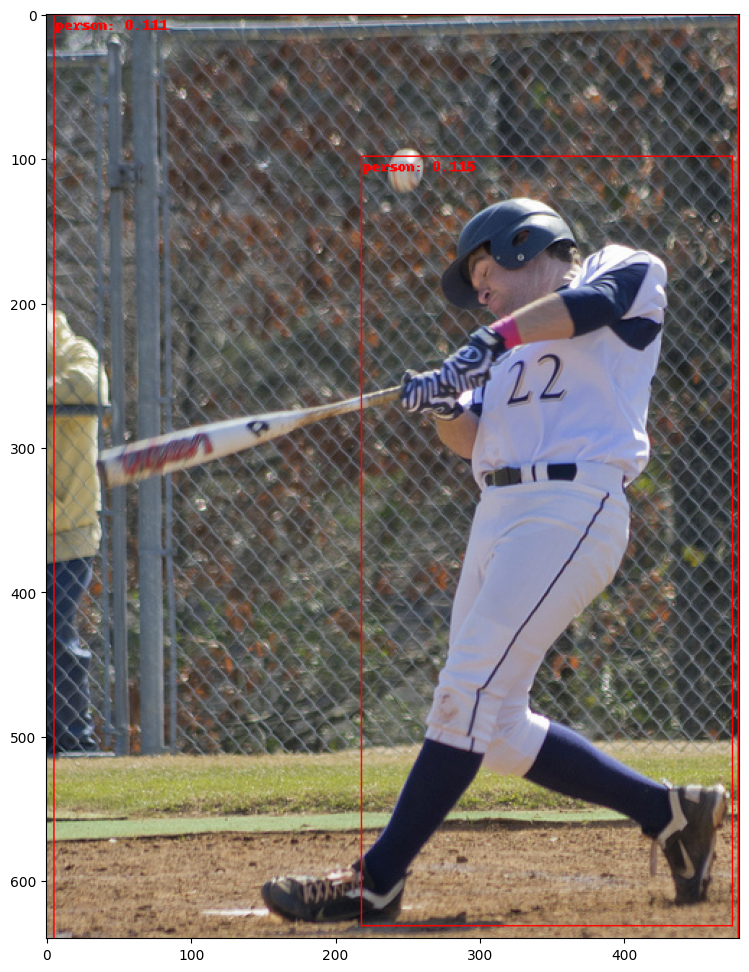

In [33]:
from torchvision.utils import draw_bounding_boxes
image = read_image("/kaggle/input/coco-2017-dataset/coco2017/test2017/000000000016.jpg")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    x = x[:3, ...].to(device) # convert RGBA -> RGB and move to device
    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"person: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))